# Network Analysis: Routing, betweenness, closeness centrality

Consider a network (non-weighted) $(N,E)$ where
$$
N=\{a_i, i=1..n\},\ E=\{(a_j, b_j)\}
$$
Start from an undirected case. Denote adjacency matrix of this network as $A$.


## Betweenness centrality

Sometimes, especially when considering resilience/vulnerability of different social or infrastructural networks, including road infrastructure, it us also relevant to understand how important the node is for the internal network topology - specifically for the shortest-path routing. In order to address this idea betweenness centrality is introduced for connected directed or undirected networks in the following way: 
$$
{\rm betweenness\_centrality}(a)=\sum_{b,c\in N,b\neq a\neq c}\frac{|g_{b,c}: a\in g_{b,c}|}{|g_{b,c}|},
$$
where $g_{b,c}$ denotes the set of all shortest or geodesic paths between $b$ and $c$. Although we typically do not care about the absolute, but rather relative values of centrality, in case we want to have the above value normalized between 0 and 1 we can introduce a normalization factor of $\frac{1}{(n-1)(n-2)}$ according to the maximal possible number of paths going through $a$. The maximal possible normalized value of $1$ is reached for the central point in a star-like network topology.

## Closeness centrality

Another concept of centrality related to the network routing is closeness centrality, which represents how close the node is to all other nodes, i.e. how short the corresponding geodesic paths are:
$$
{\rm closeness\_centrality}(a)=\frac{1}{\sum_{b\in N} d_{a,b}},
$$
or in the normalized form:
$$
{\rm closeness\_centrality}(a)=\frac{n-1}{\sum_{b\in N, b\neq a}d_{a,b}},
$$
where $d_{a,b}$ denotes the distance (length of the geogesic path) from $a$ to $b$. The second version is always normalized between $0$ and $1$ and the maximal value of $1$ is acheived if node $a$ is directly connected to all other nodes in the network. 

Notice that this definition also works pretty well for both - directed and undirected networks, however in case of undirected networks it might be also relevant to consider the incoming version of closeness
$$
{\rm closeness\_centrality}(a)=\frac{n-1}{\sum_{b\in N, b\neq a}d_{b,a}}
$$
showing how close $a$ is to other nodes rather than how close other nodes are to $a$.

In [102]:
#add necessary libraries
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stat
#make sure plots are embedded into the notebook
%pylab inline 
import statsmodels.formula.api as smf
pd.set_option('max_columns',None)

Populating the interactive namespace from numpy and matplotlib


# NYC Subway Network

In this lab we illustrate the shortest path routing (in terms of number of stations to travel or geo-distance) on the example of the NYC Subway Network. 

We'll also use this case to illustrate differences between centrality metrics and the scope of their applicability.

Our capstone team on 2017 created the data representation for the NYC subway network, collecting the information on the names and location of the stations, the lines (file NYCSubwayNodes.csv) they serve and the connections between then (file NYCSubwayStations.csv). 

Credits to:
M’cleod, L., Vecsler, R., Shi, Y., Levitskaya, E., Kulkarni, S., Malinchik, S., & Sobolevsky, S. (2017). Vulnerability of transportation networks: the New York city subway system under simultaneous disruptive events. Procedia Computer Science, 119, 42-50.

In [3]:
#station list
Stations = pd.read_csv( 'https://raw.githubusercontent.com/CUSP2021ADS/Data/main/NYCSubwayNodes.csv' , index_col=None, header=0 )
Stations.head()

,name,id,boro,lat,long,lines
0,Greenpoint Av,G26,Bk,40.731352,-73.954449,G
1,21 St,G24,Q,40.744065,-73.949724,G
2,Court Sq,G22,Q,40.746554,-73.943832,G
3,36 St,G20,Q,40.752039,-73.928781,M R
4,Queens Plaza,G21,Q,40.748973,-73.937243,E M R


In [4]:
#Split the lines into multiple columns
Stations = Stations.join(Stations['lines'].str.split(' ', expand=True)).rename({0:'line_1',1:'line_2',2:'line_3',3:'line_4'}, axis=1)
Stations

,name,id,boro,lat,long,lines,line_1,line_2,line_3,line_4
0,Greenpoint Av,G26,Bk,40.731352,-73.954449,G,G,None,None,None
1,21 St,G24,Q,40.744065,-73.949724,G,G,None,None,None
2,Court Sq,G22,Q,40.746554,-73.943832,G,G,None,None,None
3,36 St,G20,Q,40.752039,-73.928781,M R,M,R,None,None
4,Queens Plaza,G21,Q,40.748973,-73.937243,E M R,E,M,R,None
...,...,...,...,...,...,...,...,...,...,...
493,City Hall,R24,M,40.713282,-74.006978,R W,R,W,None,None
494,Canal St,R23,M,40.719527,-74.001775,R W,R,W,None,None
495,Prince St,R22,M,40.724329,-73.997702,R W,R,W,None,None
496,8 St - NYU,R21,M,40.730328,-73.992629,R W,R,W,None,None


In [5]:
#For stations with more than 1 line, unpivot to create new rows.
stli = pd.wide_to_long(Stations, stubnames='line_',i='id',j='station_line').sort_index(level=0)
stli.dropna(inplace=True)
stli.reset_index(inplace=True)
stli.rename({'id':'station_id'},axis=1,inplace=True)
stli

,station_id,station_line,boro,lines,long,name,lat,line_
0,101,1,Bx,1,-73.898583,Van Cortlandt Park - 242 St,40.889248,1
1,103,1,Bx,1,-73.900870,238 St,40.884667,1
2,104,1,Bx,1,-73.904834,231 St,40.878856,1
3,106,1,M,1,-73.909831,Marble Hill - 225 St,40.874561,1
4,107,1,M,1,-73.915279,215 St,40.869444,1
...,...,...,...,...,...,...,...,...
767,S27,1,SI,SIR,-74.084087,Grasmere,40.603117,SIR
768,S28,1,SI,SIR,-74.071402,Clifton,40.621319,SIR
769,S29,1,SI,SIR,-74.075162,Stapleton,40.627915,SIR
770,S30,1,SI,SIR,-74.074835,Tompkinsville,40.636949,SIR


In [6]:
#each station-line has 2 platforms for trains going in both directions, so we can duplicate the table
pfs = pd.concat([stli]*2)
#create a new columns to distinguish north and south-bound trains
pfs['dir'] = 'N'
pfs.iloc[:772,8] = 'S'
pfs

,station_id,station_line,boro,lines,long,name,lat,line_,dir
0,101,1,Bx,1,-73.898583,Van Cortlandt Park - 242 St,40.889248,1,S
1,103,1,Bx,1,-73.900870,238 St,40.884667,1,S
2,104,1,Bx,1,-73.904834,231 St,40.878856,1,S
3,106,1,M,1,-73.909831,Marble Hill - 225 St,40.874561,1,S
4,107,1,M,1,-73.915279,215 St,40.869444,1,S
...,...,...,...,...,...,...,...,...,...
767,S27,1,SI,SIR,-74.084087,Grasmere,40.603117,SIR,N
768,S28,1,SI,SIR,-74.071402,Clifton,40.621319,SIR,N
769,S29,1,SI,SIR,-74.075162,Stapleton,40.627915,SIR,N
770,S30,1,SI,SIR,-74.074835,Tompkinsville,40.636949,SIR,N


In [7]:
#create platform_id field based on station_id + line + dir
pfs['pf_id'] = pfs['station_id'] + '-' + pfs['line_'] + '-' + pfs['dir']
pfs

,station_id,station_line,boro,lines,long,name,lat,line_,dir,pf_id
0,101,1,Bx,1,-73.898583,Van Cortlandt Park - 242 St,40.889248,1,S,101-1-S
1,103,1,Bx,1,-73.900870,238 St,40.884667,1,S,103-1-S
2,104,1,Bx,1,-73.904834,231 St,40.878856,1,S,104-1-S
3,106,1,M,1,-73.909831,Marble Hill - 225 St,40.874561,1,S,106-1-S
4,107,1,M,1,-73.915279,215 St,40.869444,1,S,107-1-S
...,...,...,...,...,...,...,...,...,...,...
767,S27,1,SI,SIR,-74.084087,Grasmere,40.603117,SIR,N,S27-SIR-N
768,S28,1,SI,SIR,-74.071402,Clifton,40.621319,SIR,N,S28-SIR-N
769,S29,1,SI,SIR,-74.075162,Stapleton,40.627915,SIR,N,S29-SIR-N
770,S30,1,SI,SIR,-74.074835,Tompkinsville,40.636949,SIR,N,S30-SIR-N


In [8]:
#let's change the lat-long slightly for the platforms so they aren't totally on top of each other. this is not meant to be geographically accurate!
#offset the 1st platform from the station by .0006 degrees lat, which is about 200 feet north
pfs.loc[pfs.station_line ==1,'lat'] = pfs.loc[pfs.station_line ==1,'lat'] + .0006
pfs.loc[pfs.station_line ==2,'long'] = pfs.loc[pfs.station_line ==2,'long'] + .0006 #offset to east
pfs.loc[pfs.station_line ==3,'lat'] = pfs.loc[pfs.station_line ==3,'lat'] - .0006  #offset to south
pfs.loc[pfs.station_line ==4,'long'] = pfs.loc[pfs.station_line ==4,'long'] - .0006 #offset to west

#and let's offset the north platforms from the south by adding .0001 degrees lat or ~35 feet north
pfs.loc[pfs.dir =='N','lat'] = pfs.loc[pfs.dir =='N','lat'] + .0006


In [9]:
#finally, let's concatenate the stations to the platforms
Stations.rename({'id':'station_id','lines':'line_'},axis=1,inplace=True)
Stations.drop(['line_1','line_2','line_3','line_4'],axis = 1,inplace=True)
Stations[['pf_id','dir','station_line']] = 'station'
nodes = pd.concat([pfs,Stations])

In [356]:
nodes['node_id'] = np.where(nodes['pf_id'] != 'station',nodes['pf_id'],nodes['station_id'])
nodes.reset_index(inplace=True,drop=True)
nodes

,station_id,station_line,boro,lines,long,name,lat,line_,dir,pf_id,node_id
0,101,1,Bx,1,-73.898583,Van Cortlandt Park - 242 St,40.889848,1,S,101-1-S,101-1-S
1,103,1,Bx,1,-73.900870,238 St,40.885267,1,S,103-1-S,103-1-S
2,104,1,Bx,1,-73.904834,231 St,40.879456,1,S,104-1-S,104-1-S
3,106,1,M,1,-73.909831,Marble Hill - 225 St,40.875161,1,S,106-1-S,106-1-S
4,107,1,M,1,-73.915279,215 St,40.870044,1,S,107-1-S,107-1-S
...,...,...,...,...,...,...,...,...,...,...,...
2037,R24,station,M,NaN,-74.006978,City Hall,40.713282,R W,station,station,R24
2038,R23,station,M,NaN,-74.001775,Canal St,40.719527,R W,station,station,R23
2039,R22,station,M,NaN,-73.997702,Prince St,40.724329,R W,station,station,R22
2040,R21,station,M,NaN,-73.992629,8 St - NYU,40.730328,R W,station,station,R21


In [123]:
nodes.iloc[100:140]

,station_id,station_line,boro,lines,long,name,lat,line_,dir,pf_id,node_id
100,229,2,M,2 3,-74.005971,Fulton St,40.709416,3,S,229-3-S,229-3-S
101,230,1,M,2 3,-74.009100,Wall St,40.707421,2,S,230-2-S,230-2-S
102,230,2,M,2 3,-74.008500,Wall St,40.706821,3,S,230-3-S,230-3-S
103,231,1,Bk,2 3,-73.993086,Clark St,40.698066,2,S,231-2-S,231-2-S
104,231,2,Bk,2 3,-73.992486,Clark St,40.697466,3,S,231-3-S,231-3-S
105,232,1,Bk,2 3,-73.989998,Borough Hall,40.693819,2,S,232-2-S,232-2-S
106,232,2,Bk,2 3,-73.989398,Borough Hall,40.693219,3,S,232-3-S,232-3-S
107,233,1,Bk,2 3,-73.985065,Hoyt St,40.691145,2,S,233-2-S,233-2-S
108,233,2,Bk,2 3,-73.984465,Hoyt St,40.690545,3,S,233-3-S,233-3-S
109,234,1,Bk,2 3 4 5,-73.980492,Nevins St,40.688846,2,S,234-2-S,234-2-S


In [ ]:
#next step is edges. the edge list actually shows multiple edges for each line and direction. for example, station 230 (Wall Street) 
# and station 231 (Clark Street) are already connected by 4 edges: the 2 and 3 trains, northbound and southbound. However, because the stations
# are represented as single nodes, these 4 edges are indistinguishable from one another, and networkx only uses 1 of them anyway.

#so for each of these existing edges, we need to reset the origin and destination based on the platform_id. In the example above, we need to
# end up with the following edges:
# 230-2-S --> 231-2-S
# 230-3-S --> 231-3-S
# 231-2-N --> 230-2-N
# 231-3-N --> 230-3-N

#actually, we don't need this to be a directed graph, so don't worry if northbound edges are going south.
# But it is important that only edges with the same line and direction are connected. So we can't have a southbound train going to a northbound
# platform, and we can't have a 2 train going to a 3 platform (even though in actuality they do share a platfom)

#So basically, for each unique origin and destination in the edge list, we need to look up the lines that are serving both of those stations.
# If the stations have line(s) in common, we draw an edge between the corresponding platforms in both directions

# I think the easiest way to do this in practice is to add a bunch of columns to the edge list, for each of the ~31 subway lines
# If both the origin and destination of the edge contain the same line, mark that as a 1, otherwise if one/both doesn't have that line mark 0

#After all of this, don't forget to add edges between the stations and platforms!


In [270]:
#connection list
Links = pd.read_csv( 'https://raw.githubusercontent.com/CUSP2021ADS/Data/main/NYCSubwayEdges.csv' , index_col=None, header=0 )
Links.head()

,origin,dest
0,G26,G24
1,G26,G28
2,G24,G26
3,G24,G22
4,G22,G24


In [273]:
Links.shape

(1848, 2)

In [300]:
#the repeated edges are of no use to us, so let's get unique edges.
uLinks = Links.drop_duplicates().reset_index()
uLinks.drop('index',axis=1,inplace=True)
uLinks.shape

(1208, 2)

In [301]:
#Also, we don't need a directed graph because we will incorporate that logic into the platforms, i.e. only northbound platforms can have an edge, but the direction of that edge
#isn't important. If the northbound edges are actually going south geographically, it doesn't make a difference. So let's remove duplicate edges that are A-->B and B-->A
uuLinks = uLinks[pd.DataFrame(np.sort(uLinks[['origin','dest']].values,1)).duplicated()].sort_values('origin')
uuLinks.reset_index(inplace=True)
uuLinks

,index,origin,dest
0,127,101,103
1,132,104,103
2,133,104,106
3,130,107,108
4,131,107,106
...,...,...,...
598,576,S27,S26
599,582,S28,S27
600,583,S29,S28
601,584,S29,S30


In [127]:
pfs.line_.unique()

array(['1line', '2line', '3line', '5line', '4line', '6line', '7line',
       'Sline', 'Aline', 'Cline', 'Bline', 'Dline', 'Eline', 'Fline',
       'Gline', 'Qline', 'Mline', 'Nline', 'Jline', 'Zline', 'Rline',
       'Lline', 'Wline', 'SIRline'], dtype=object)

In [302]:
d = pd.DataFrame(np.zeros((uuLinks.shape[0], 24)))
d.columns = pfs.line_.unique()
uuLinks = pd.concat([uuLinks,d],axis=1)
uuLinks

,index,origin,dest,1,2,3,5,4,6,7,S,A,C,B,D,E,F,G,Q,M,N,J,Z,R,L,W,SIR
0,127,101,103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,132,104,103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,133,104,106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,130,107,108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,131,107,106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,576,S27,S26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
599,582,S28,S27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
600,583,S29,S28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
601,584,S29,S30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [303]:
i = 0
for o, d in zip(uuLinks.origin, uuLinks.dest):
    o_lines = Stations.loc[Stations['station_id'] == o,'line_'].str.split(' ').values[0]
    d_lines = Stations.loc[Stations['station_id'] == d,'line_'].str.split(' ').values[0]
    common = [value for value in o_lines if value in d_lines]
    for lc in common:
        uuLinks.loc[uuLinks.index[i],lc] =1
    i +=1

In [304]:
uuLinks

,index,origin,dest,1,2,3,5,4,6,7,S,A,C,B,D,E,F,G,Q,M,N,J,Z,R,L,W,SIR
0,127,101,103,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,132,104,103,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,133,104,106,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,130,107,108,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,131,107,106,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,576,S27,S26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
599,582,S28,S27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
600,583,S29,S28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
601,584,S29,S30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [342]:
#I got the output I wanted, but it's tricky because some stations are actually represented as multiple nodes, e.g. Union Sq vs Union Sq - 14 St.
# There are actually quite a few of these (146 edges). I will draw edges between the stations themselves, not the platforms. So basically I can leave them as-is.
# everything else is a platform-platform edge (until we draw station-platform edges)

uuLinks['total_edges'] = 0
for i in uuLinks.index:
    uuLinks.loc[i, 'total_edges'] = uuLinks.loc[i, '1':'total_edges'].sum()

pfs_edges = uuLinks[uuLinks['total_edges'] > 0]
ss_edges = uuLinks[uuLinks['total_edges'] == 0]


In [343]:
pfs_edges.head()

,index,origin,dest,1,2,3,5,4,6,7,S,A,C,B,D,E,F,G,Q,M,N,J,Z,R,L,W,SIR,total_edges
0,127,101,103,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,132,104,103,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,133,104,106,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,130,107,108,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,131,107,106,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [344]:
#each platform edge needs to be multiplied by the total_edges. Let's use wide to long, then filter out all of the 0 edges
pfs_edges_tr = pfs_edges.drop(['total_edges','index'],axis=1).melt(id_vars=['origin','dest'])
pfs_edges_tr = pfs_edges_tr[pfs_edges_tr['value'] >0]
pfs_edges_tr = pfs_edges_tr.rename({'variable':'line'},axis=1).drop('value',axis=1)
pfs_edges_tr

,origin,dest,line
0,101,103,1
1,104,103,1
2,104,106,1
3,107,108,1
4,107,106,1
...,...,...,...
12715,S27,S26,SIR
12716,S28,S27,SIR
12717,S29,S28,SIR
12718,S29,S30,SIR


In [345]:
#rename the origin and destination based on the line and direction.
pfs_edges_tr['origin_stli'] = pfs_edges_tr['origin'] + '-' + pfs_edges_tr['line']
pfs_edges_tr['dest_stli'] = pfs_edges_tr['dest'] + '-' + pfs_edges_tr['line']

#double the dataframe for northbound and southbound platforms
pfs_edges_tr = pd.concat([pfs_edges_tr]*2)
pfs_edges_tr['dir'] = 'N'
pfs_edges_tr.iloc[:775,5] = 'S'
pfs_edges_tr

,origin,dest,line,origin_stli,dest_stli,dir
0,101,103,1,101-1,103-1,S
1,104,103,1,104-1,103-1,S
2,104,106,1,104-1,106-1,S
3,107,108,1,107-1,108-1,S
4,107,106,1,107-1,106-1,S
...,...,...,...,...,...,...
12715,S27,S26,SIR,S27-SIR,S26-SIR,N
12716,S28,S27,SIR,S28-SIR,S27-SIR,N
12717,S29,S28,SIR,S29-SIR,S28-SIR,N
12718,S29,S30,SIR,S29-SIR,S30-SIR,N


In [346]:
pfs_edges_tr['origin'] = pfs_edges_tr['origin_stli'] + '-' + pfs_edges_tr['dir']
pfs_edges_tr['dest'] = pfs_edges_tr['dest_stli'] + '-' + pfs_edges_tr['dir']
pfs_edges_tr.drop(['origin_stli','dest_stli','dir'],axis=1,inplace=True)
pfs_edges_tr.reset_index(inplace=True, drop=True)
pfs_edges_tr

,origin,dest,line
0,101-1-S,103-1-S,1
1,104-1-S,103-1-S,1
2,104-1-S,106-1-S,1
3,107-1-S,108-1-S,1
4,107-1-S,106-1-S,1
...,...,...,...
1545,S27-SIR-N,S26-SIR-N,SIR
1546,S28-SIR-N,S27-SIR-N,SIR
1547,S29-SIR-N,S28-SIR-N,SIR
1548,S29-SIR-N,S30-SIR-N,SIR


In [347]:
#we now have all station-to-station edges and platform-to-platform edges. Now let's make a final set of edges between the station and its platforms.
#We can just use the platforms dataframe to get the platform ID and the station ID the platform belongs to
stpf_edges = pfs[['station_id','pf_id','line_']]
stpf_edges.rename({'station_id':'origin','pf_id':'dest','line_':'line'},axis=1,inplace=True)
stpf_edges

C:\Users\Gabriel\anaconda3\envs\ADS2\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,origin,dest,line
0,101,101-1-S,1
1,103,103-1-S,1
2,104,104-1-S,1
3,106,106-1-S,1
4,107,107-1-S,1
...,...,...,...
767,S27,S27-SIR-N,SIR
768,S28,S28-SIR-N,SIR
769,S29,S29-SIR-N,SIR
770,S30,S30-SIR-N,SIR


In [348]:
#remove unnecessary columns from the station-to-station edge dataframe
ss_edges

,index,origin,dest,1,2,3,5,4,6,7,S,A,C,B,D,E,F,G,Q,M,N,J,Z,R,L,W,SIR,total_edges
8,960,112,A09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
25,624,127,902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
63,1098,222,415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
71,1087,228,A36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
73,1085,228,E01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,362,R31,235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
565,854,R33,F23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
578,1108,S01,A45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
581,1112,S04,239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [349]:
ss_edges = ss_edges[['origin','dest']]
ss_edges['line'] = 'station'
ss_edges.reset_index(inplace=True, drop=True)
ss_edges

C:\Users\Gabriel\AppData\Local\Temp/ipykernel_61676/2532888732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ss_edges['line'] = 'station'


,origin,dest,line
0,112,A09,station
1,127,902,station
2,222,415,station
3,228,A36,station
4,228,E01,station
...,...,...,...
68,R31,235,station
69,R33,F23,station
70,S01,A45,station
71,S04,239,station


In [364]:
#finally! let's concat the station-to-station, platform-to-platform, and station-to-platform edges
edges = pd.concat([ss_edges.reset_index(drop=True), stpf_edges.reset_index(drop=True), pfs_edges_tr.reset_index(drop=True)],axis=0)
edges.reset_index(inplace=True,drop=True)
edges

,origin,dest,line
0,112,A09,station
1,127,902,station
2,222,415,station
3,228,A36,station
4,228,E01,station
...,...,...,...
3162,S27-SIR-N,S26-SIR-N,SIR
3163,S28-SIR-N,S27-SIR-N,SIR
3164,S29-SIR-N,S28-SIR-N,SIR
3165,S29-SIR-N,S30-SIR-N,SIR


In [218]:
#create a dictionary of subway stations by name and location
StPos={Stations.station_id[c]:(Stations.long[c],Stations.lat[c]) for c in Stations.index}
StName={Stations.station_id[c]:Stations.name[c] for c in Stations.index}

In [352]:
nodes.head()

,station_id,station_line,boro,lines,long,name,lat,line_,dir,pf_id,node_id
0,101,1,Bx,1,-73.898583,Van Cortlandt Park - 242 St,40.889848,1,S,101-1-S,101-1-S
1,103,1,Bx,1,-73.900870,238 St,40.885267,1,S,103-1-S,103-1-S
2,104,1,Bx,1,-73.904834,231 St,40.879456,1,S,104-1-S,104-1-S
3,106,1,M,1,-73.909831,Marble Hill - 225 St,40.875161,1,S,106-1-S,106-1-S
4,107,1,M,1,-73.915279,215 St,40.870044,1,S,107-1-S,107-1-S


In [362]:
#create a dictionary of subway stations by name and location
nodePos={nodes.node_id[c]:(nodes.long[c],nodes.lat[c]) for c in nodes.index}
nodeName={nodes.node_id[c]:nodes.name[c] for c in nodes.index}

In [277]:
#this is the original network graph without platforms, lines
NYCSubway=nx.DiGraph()
for i in Links.index:
   NYCSubway.add_edge(Links.origin[i],Links.dest[i])   

In [278]:
len(NYCSubway.edges)

1208

In [372]:
#this is the graph with platforms and lines
uuNYCSubway=nx.Graph()
for i in edges.index:
   uuNYCSubway.add_edge(edges.origin[i],edges.dest[i])   

In [366]:
len(uuNYCSubway.edges)

3167

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


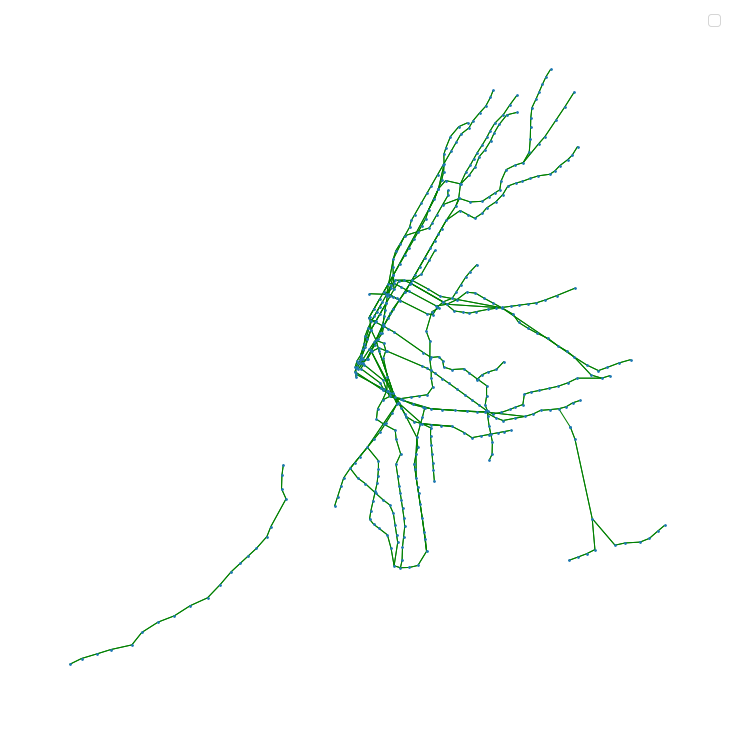

In [279]:
#visualize the subway newtork
plt.figure(figsize = (10,10))
nx.draw(NYCSubway,pos=StPos,with_labels=False,arrows=False,node_size=3,width=1,edge_color='green')
#plt.plot(subSample.long, subSample.lat, 'o', color='red', label='unknown ridership locations')
plt.legend(fontsize=15)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


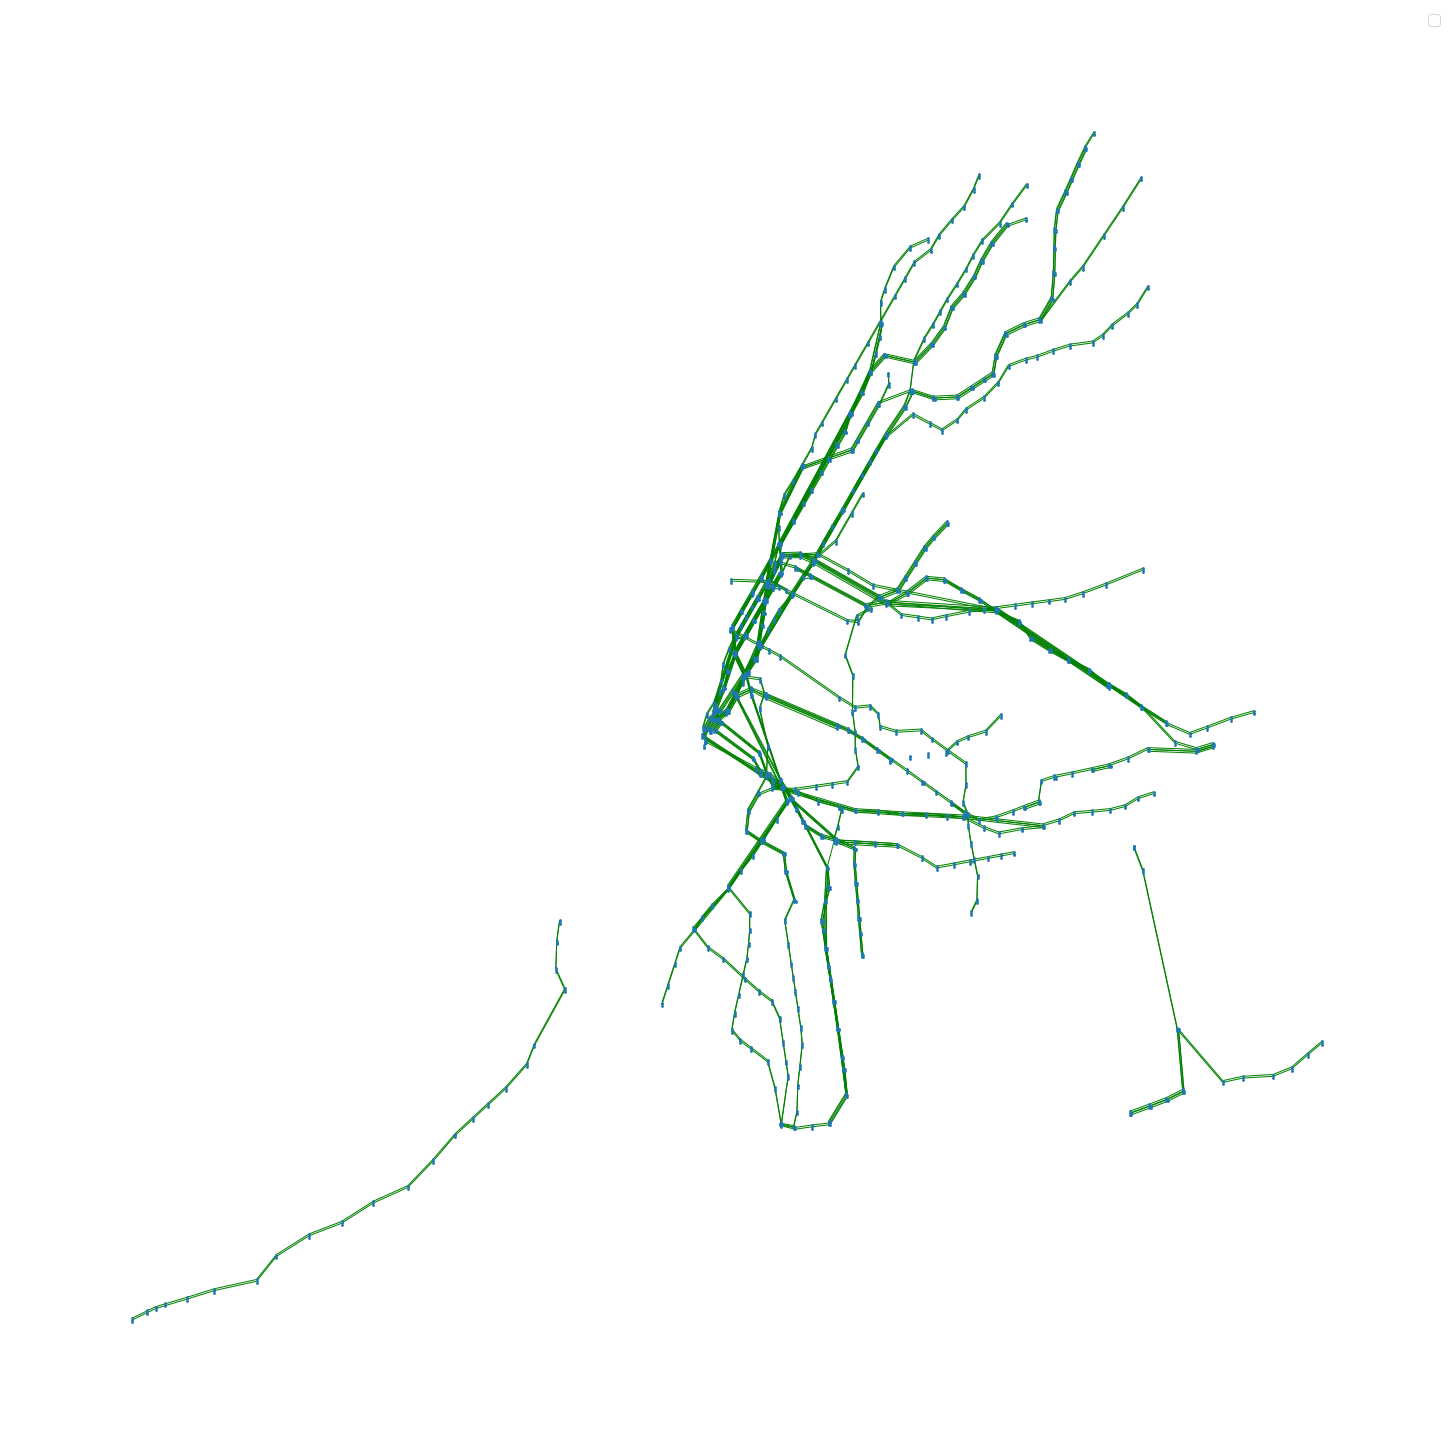

In [373]:
#visualize the subway newtork
plt.figure(figsize = (20,20))
nx.draw(uuNYCSubway,pos=nodePos,with_labels=False,arrows=False,node_size=3,width=1,edge_color='green')
plt.legend(fontsize=15)

In [35]:
neib = nx.single_source_shortest_path_length(NYCSubway, 'A41', cutoff=2)
list(neib.keys())

['A41',
 'A40',
 'F20',
 'R29',
 'A42',
 'F18',
 'G36',
 'A43',
 'F21',
 'A46',
 'A38',
 'R28',
 'F16',
 'R30']

#### Task 1a. Find shortest path between Jay Str.-Metrotech (A41) and Junction Blvd, Queens (707)

In [375]:
path1=nx.shortest_path(uuNYCSubway,'A41','707')
path2=nx.shortest_path(uuNYCSubway,'A40','F16')

In [376]:
path1

['A41',
 'A41-A-S',
 'A40-A-S',
 'A38-A-S',
 'A38',
 '418',
 '418-4-S',
 '640-4-S',
 '635-4-S',
 '631-4-S',
 '629-4-S',
 '629',
 'R11',
 'R11-R-S',
 'G21-R-S',
 'G14-R-S',
 'G14',
 '710',
 '710-7-S',
 '709-7-S',
 '708-7-S',
 '707-7-S',
 '707']

In [381]:
nodes[nodes['node_id']=='A38']

,station_id,station_line,boro,lines,long,name,lat,line_,dir,pf_id,node_id
1749,A38,station,M,NaN,-74.007691,Fulton St,40.710197,A C,station,station,A38


In [384]:
nodes[nodes['node_id']=='R11']

,station_id,station_line,boro,lines,long,name,lat,line_,dir,pf_id,node_id
1956,R11,station,M,NaN,-73.967258,Lexington Av/59 St,40.76266,N W R,station,station,R11


In [377]:
len(path1)

23

In [388]:
#auxiliary function - visualize path on the map
def visualize_path(path):
    plt.figure(figsize = (15,18))
    nx.draw(uuNYCSubway,pos=nodePos,with_labels=False,arrows=False,node_size=1,width=1,edge_color='green')
    x=[nodePos[v][0] for v in path]
    y=[nodePos[v][1] for v in path]
    plt.plot(x,y,'ro-')
    plt.plot([x[0],x[-1]],[y[0],y[-1]],'bs',markersize=10)

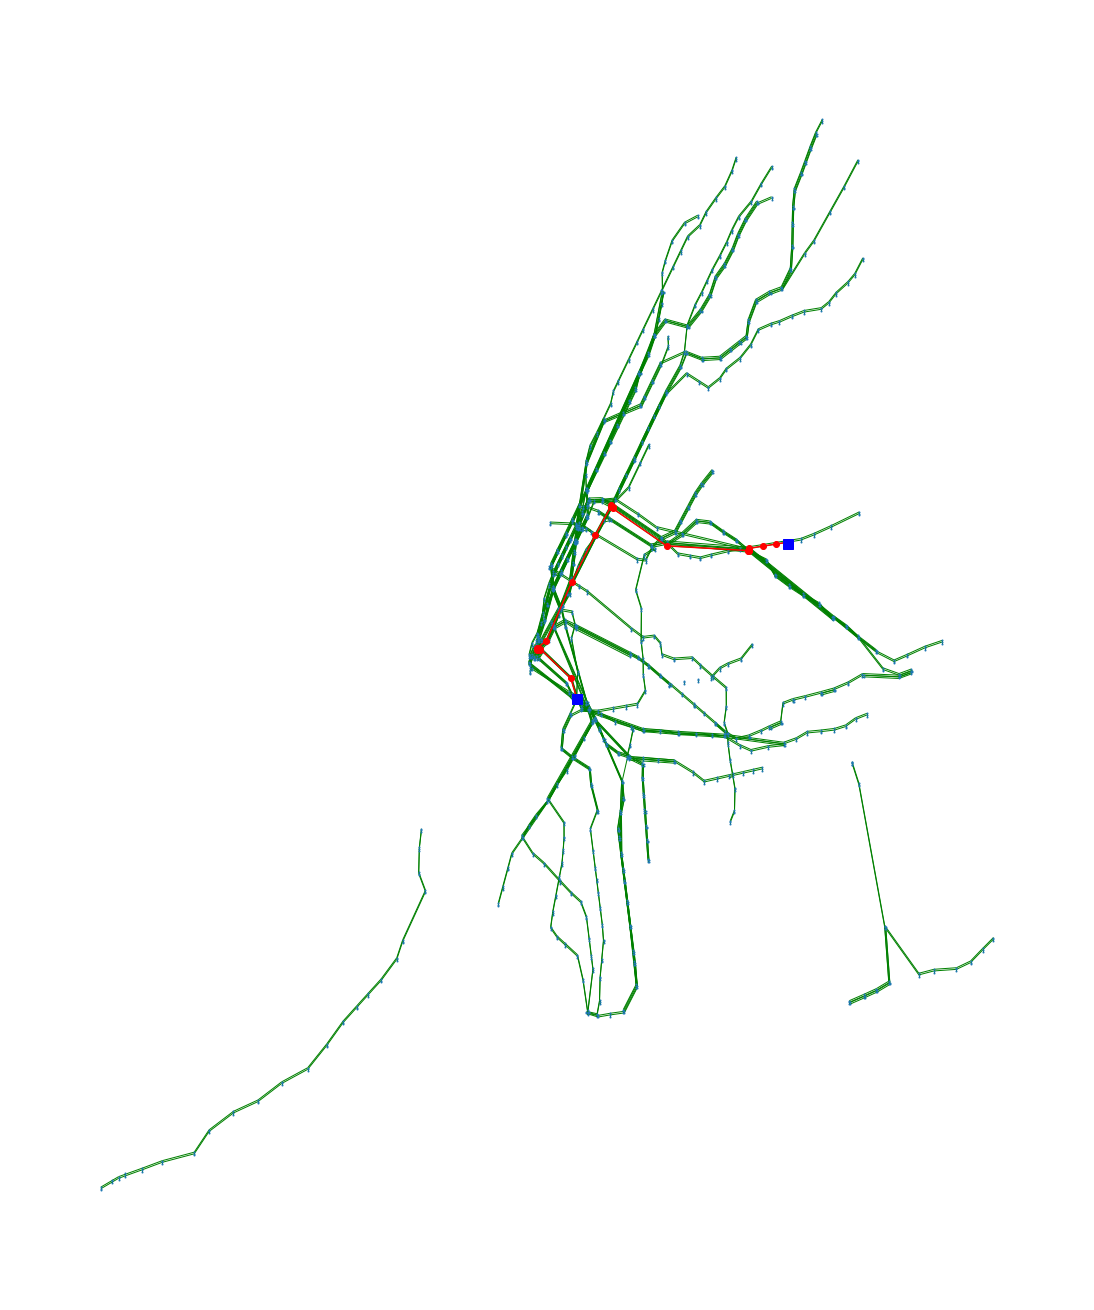

In [389]:
ax1 = visualize_path(path1)
#ax1 = visualize_path(path2)

#### Task 1b. Find shortest path between Jay Str.-Metrotech (A41) and Junction Blvd, Queens (707) in terms of travel distance 

In [390]:
#auxiliary function: geodesic distance on the Earth surface between two lat-long points
from math import sin, cos, sqrt, atan2, radians
def geodist(lon1,lat1,lon2,lat2):
    lat1 = radians(lat1)
    lon1 = radians(lon1)  
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [394]:
#compute and assing lengths the all the edges
nx.set_edge_attributes(uuNYCSubway, 'dist', 0)
for e in uuNYCSubway.edges():
   uuNYCSubway[e[0]][e[1]]['dist']=geodist(nodePos[e[0]][0],nodePos[e[0]][1],nodePos[e[1]][0],nodePos[e[1]][1])

In [395]:
path1=nx.shortest_path(uuNYCSubway,'A41','707',weight='dist') #shorest path according to dist

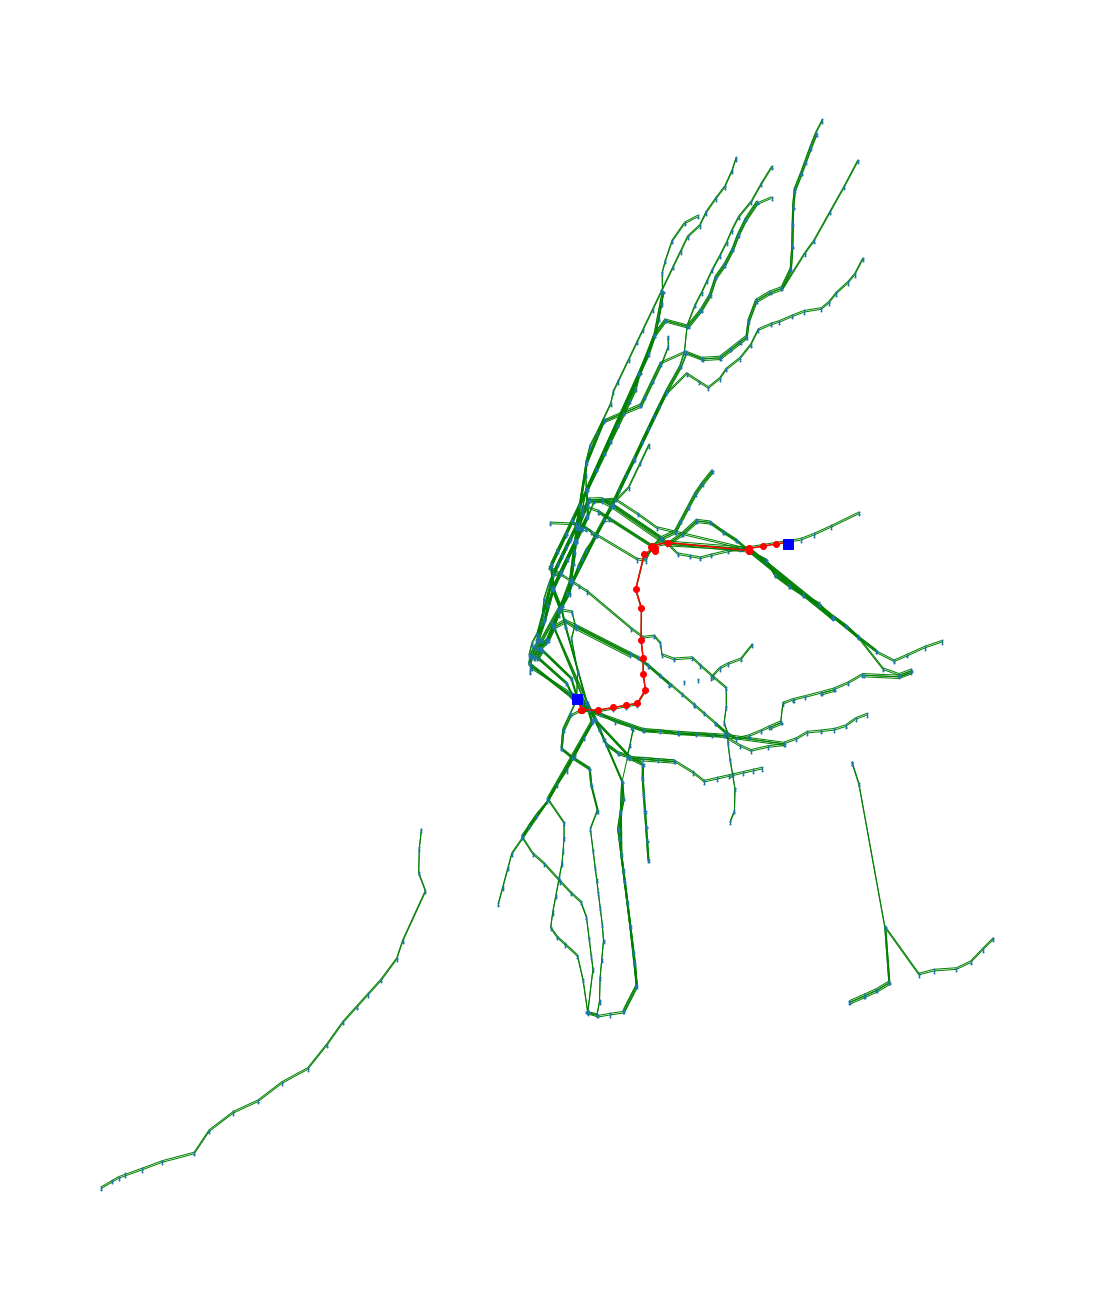

In [396]:
visualize_path(path1)

#### Task 2. Find the diameter of the graph in terms of distance and number of stations and output its value, beginning/end of the longest path, visualize the paths

In [22]:
#compute travel times to different locations
allpaths=dict(nx.shortest_path_length(NYCSubway))
allpathsD=dict(nx.shortest_path_length(NYCSubway,weight='dist'))

In [23]:
diameter=0; i0=0; j0=0;
for i in allpaths.items():
  for j in i[1].items():
    if j[1]>diameter:
      diameter=j[1]
      i0=i[0]
      j0=j[0]  
print('{0} - {1} : {2}'.format(StName[i0],StName[j0],diameter))

Far Rockaway - Mott Av - Wakefield - 241 St : 49


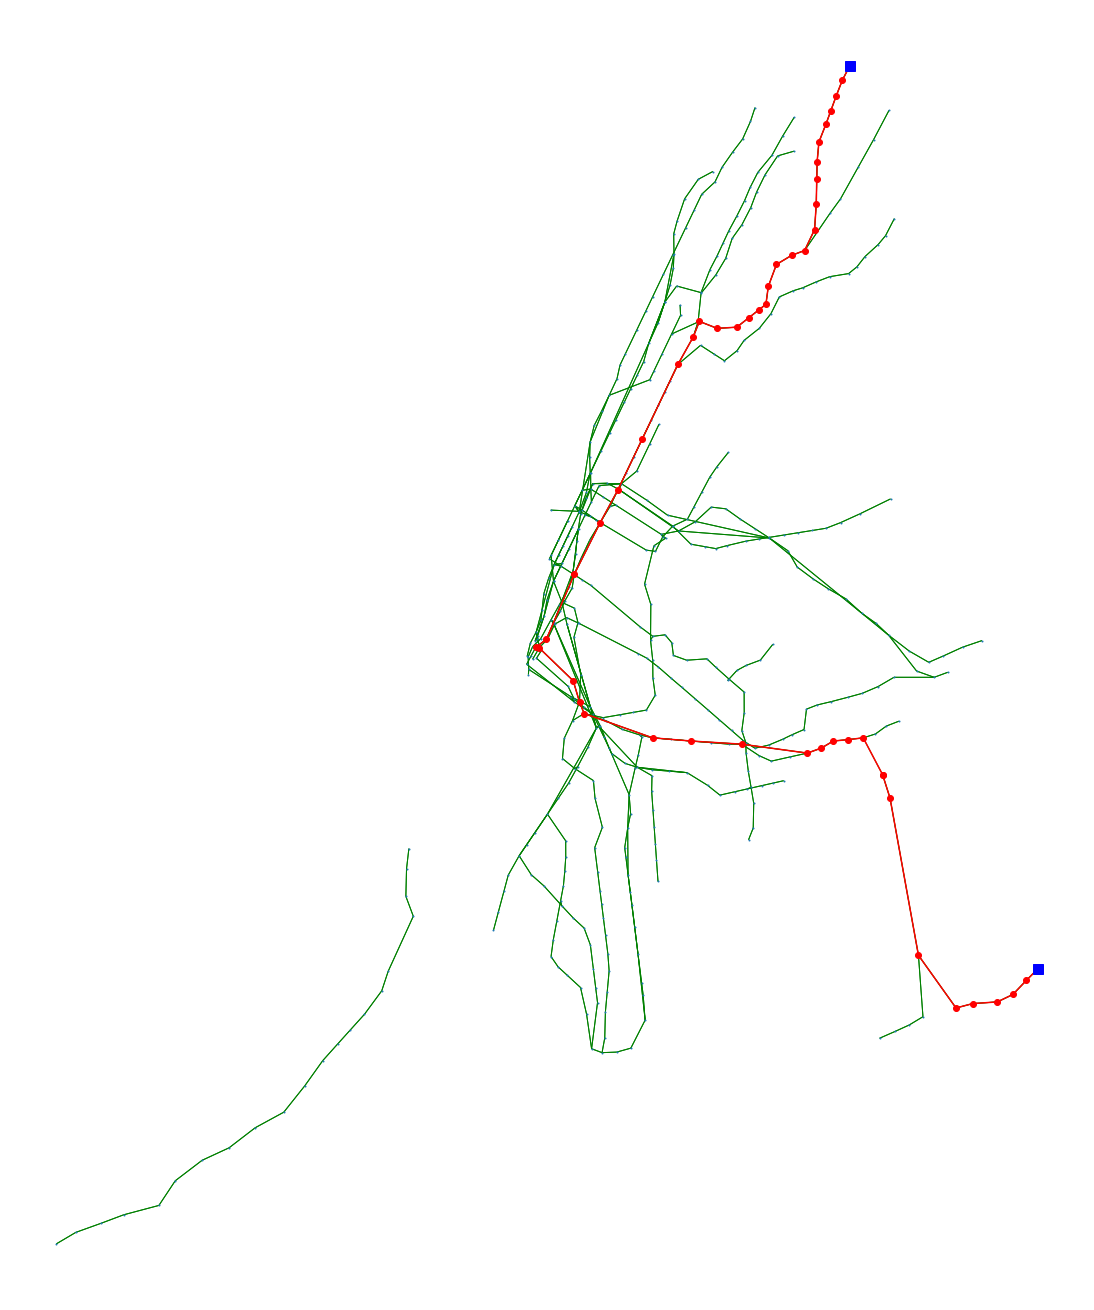

In [24]:
Lpath=nx.shortest_path(NYCSubway,i0,j0)
visualize_path(Lpath)

In [25]:
diameter=0; i0=0; j0=0;
for i in allpathsD.items():
  for j in i[1].items():
    if j[1]>diameter:
      diameter=j[1]
      i0=i[0]
      j0=j[0]  
print('{0} - {1} : {2}'.format(StName[i0],StName[j0],diameter))

Far Rockaway - Mott Av - Wakefield - 241 St : 54.96209465817458


#### Task 3. Compute degree, pagerank, betweenness and closeness centrality for NYC Subway network, list top 10 nodes by each. Visualize the above top 10 nodes by each metric

In [26]:
#output top tn centrality scores, given the dictionary d
def topdict(d,tn):
    ind=sorted(d, key=d.get, reverse=True)
    for i in range(0,tn):
       print('{0}|{1} - {2} : {3}'.format(i+1,ind[i],StName[ind[i]],d[ind[i]]))
    return ind

In [27]:
mc1=dict(nx.degree(NYCSubway))
ind1=topdict(mc1,10)

1|R16 - Times Sq - 42 St : 14
2|A27 - 42 St - Port Authority Bus Terminal : 14
3|127 - Times Sq - 42 St : 14
4|R31 - Atlantic Av - Barclays Ctr : 14
5|G14 - Jackson Hts - Roosevelt Av : 12
6|A51 - Broadway Jct : 12
7|725 - Times Sq - 42 St : 12
8|631 - Grand Central - 42 St : 12
9|635 - 14 St - Union Sq : 12
10|B08 - Lexington Av/63 St : 12


Clearly the degree rankings do not give really distrinctive values and reflect just the local topology of the infrastructural network

In [28]:
mc2 = nx.pagerank(NYCSubway,0.85)
ind2=topdict(mc2,10)

1|G14 - Jackson Hts - Roosevelt Av : 0.0042911876301375855
2|A51 - Broadway Jct : 0.004240855133119337
3|239 - Franklin Av : 0.004163060639263965
4|R31 - Atlantic Av - Barclays Ctr : 0.00398003495263838
5|B08 - Lexington Av/63 St : 0.003829477846803269
6|132 - 14 St : 0.003814653461670501
7|127 - Times Sq - 42 St : 0.003770399542623098
8|R16 - Times Sq - 42 St : 0.003643932546934742
9|629 - 59 St : 0.0036294956162624473
10|A27 - 42 St - Port Authority Bus Terminal : 0.003624071809766451


So the rankings happen to be completely distinctive now. Now visualize the top 10 stations in terms of pagerank.

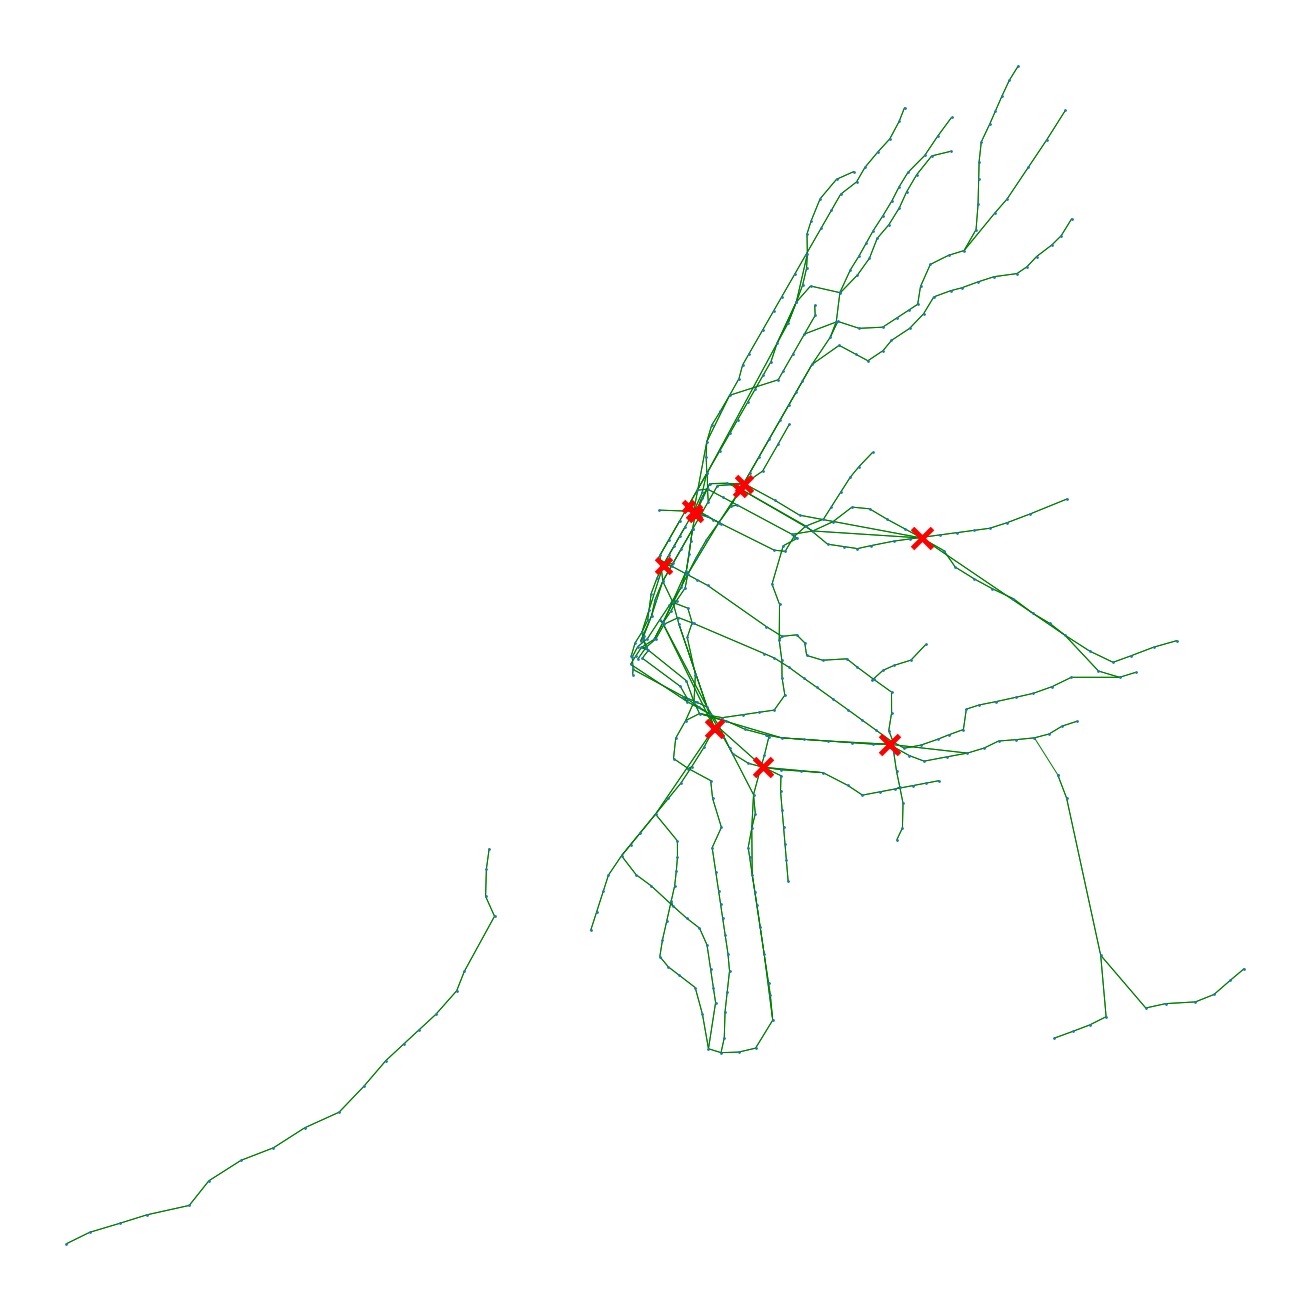

In [29]:
plt.figure(figsize = (18,18))
nx.draw(NYCSubway,pos=StPos,with_labels=False,arrows=False,node_size=3,width=1,edge_color='green')
for i in range(0,10):
  plt.plot(StPos[ind2[i]][0],StPos[ind2[i]][1],'xr',markersize=20-i,markeredgewidth=5)

In [30]:
mc3 = nx.betweenness_centrality(NYCSubway)
ind3=topdict(mc3,10)

1|Q01 - Canal St : 0.3079728700189545
2|R20 - 14 St - Union Sq : 0.3066409614707738
3|629 - 59 St : 0.27912683117439946
4|631 - Grand Central - 42 St : 0.25803092804774846
5|635 - 14 St - Union Sq : 0.2560377812635025
6|R31 - Atlantic Av - Barclays Ctr : 0.2392478997188843
7|621 - 125 St : 0.19306583122073165
8|626 - 86 St : 0.1890734427505319
9|R16 - Times Sq - 42 St : 0.14292663038828904
10|A41 - Jay St - MetroTech : 0.1365341160293671


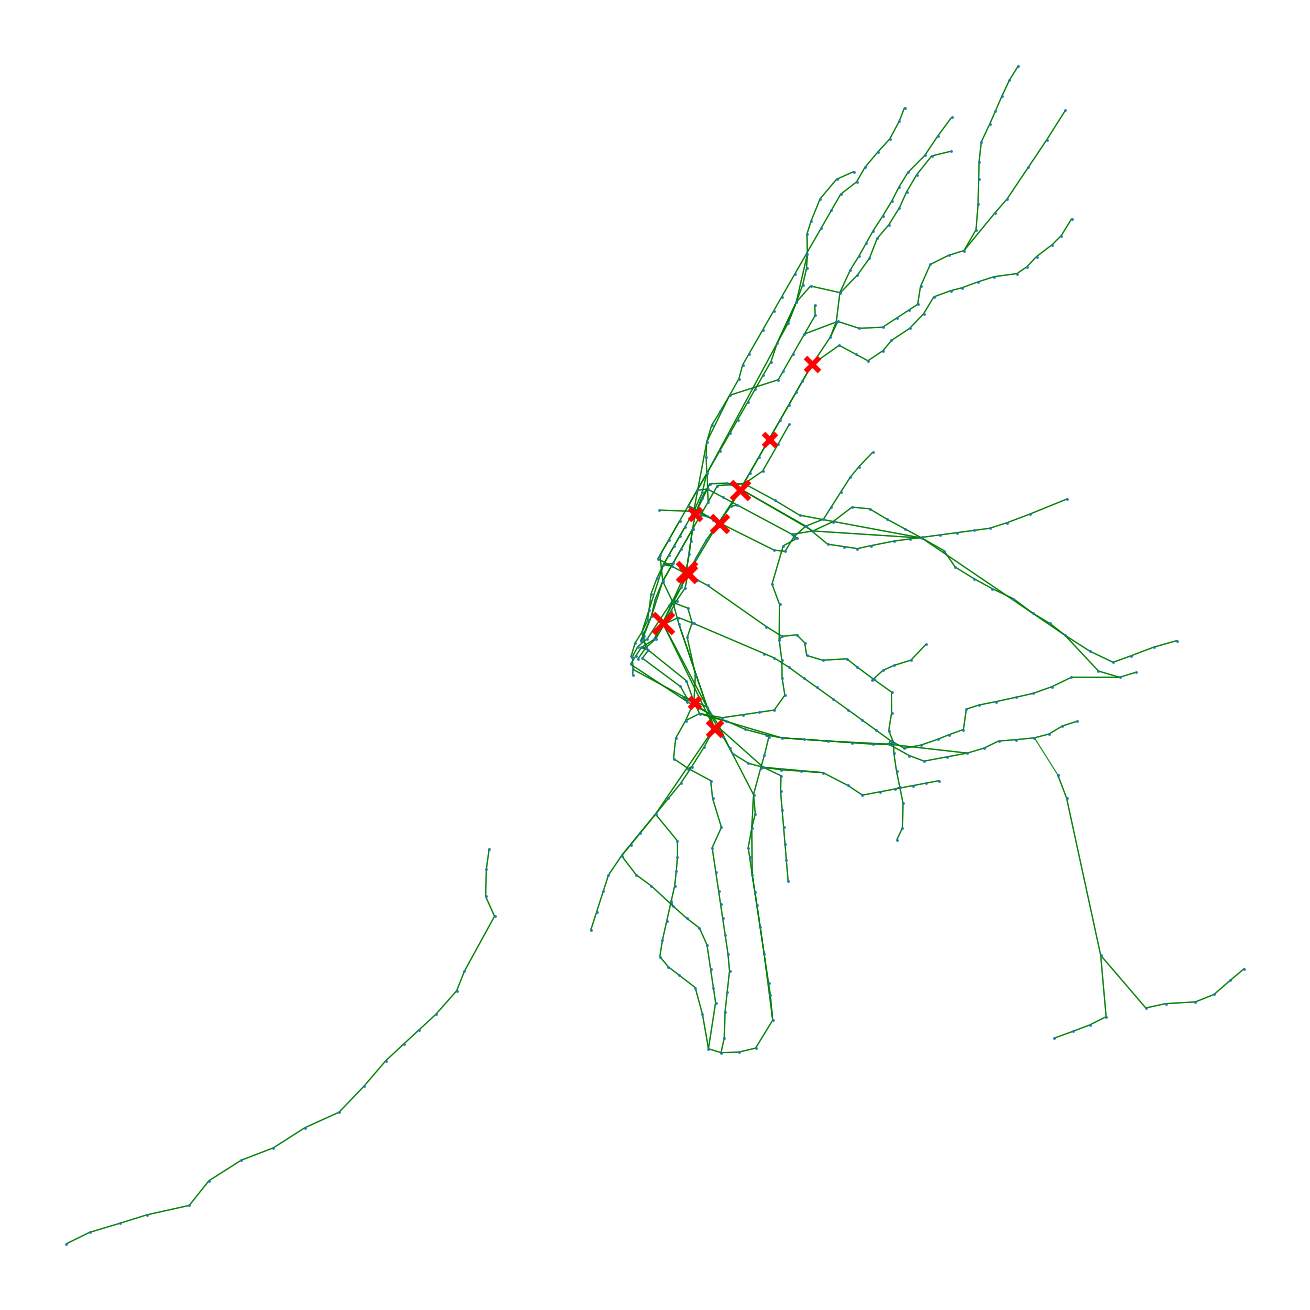

In [31]:
plt.figure(figsize = (18,18))
nx.draw(NYCSubway,pos=StPos,with_labels=False,arrows=False,node_size=3,width=1,edge_color='green')
for i in range(0,10):
  plt.plot(StPos[ind3[i]][0],StPos[ind3[i]][1],'xr',markersize=20-i,markeredgewidth=5)

In [32]:
mc4 = nx.closeness_centrality(NYCSubway)
ind4=topdict(mc4,10)

1|R20 - 14 St - Union Sq : 0.11064998122589911
2|Q01 - Canal St : 0.10883779463549421
3|635 - 14 St - Union Sq : 0.1084199912011929
4|631 - Grand Central - 42 St : 0.10744044777141513
5|R17 - 34 St - Herald Sq : 0.10514065223977943
6|L03 - Union Sq - 14 St : 0.1050184809032238
7|R16 - Times Sq - 42 St : 0.10467790672378317
8|R30 - DeKalb Av : 0.1046536645036063
9|R31 - Atlantic Av - Barclays Ctr : 0.10450844665276873
10|640 - Brooklyn Bridge - City Hall : 0.10414715909808067


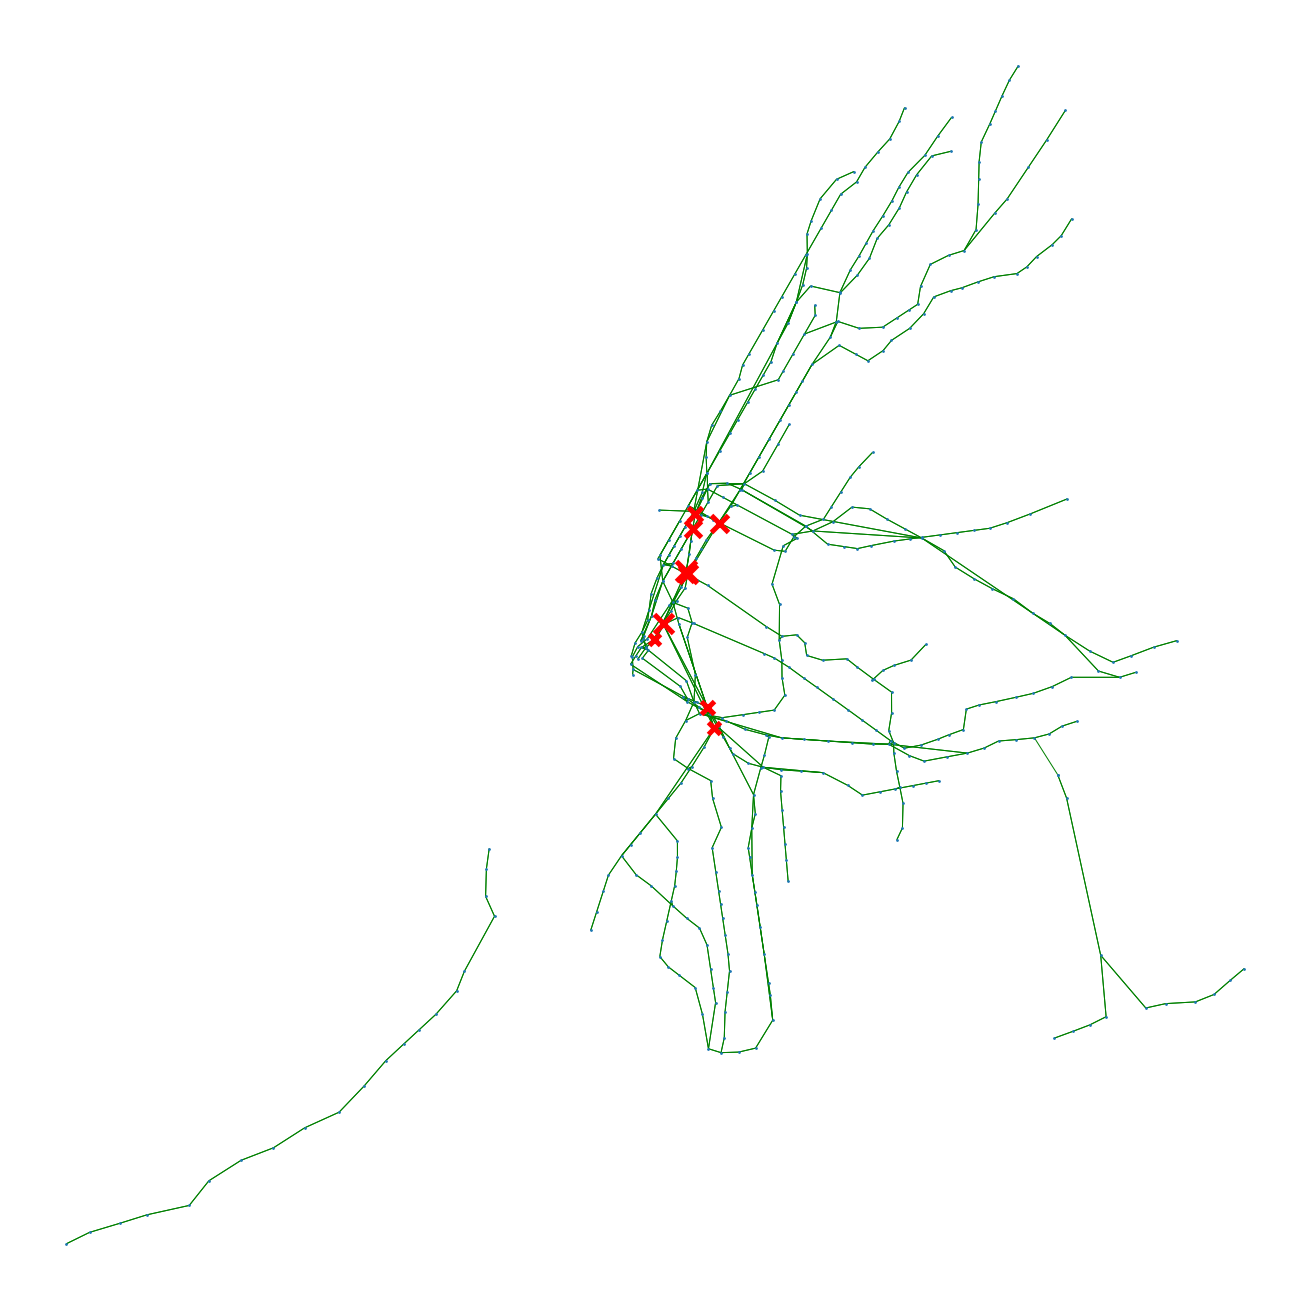

In [33]:
plt.figure(figsize = (18,18))
nx.draw(NYCSubway,pos=StPos,with_labels=False,arrows=False,node_size=3,width=1,edge_color='green')
for i in range(0,10):
  plt.plot(StPos[ind4[i]][0],StPos[ind4[i]][1],'xr',markersize=20-i,markeredgewidth=5)